In [17]:
import os.path as osp
import os
import torch
from overflowDataset import OverFlowDataset
from torch_geometric.datasets import JODIEDataset
from tqdm import tqdm
from neighbor_sampler import NeighborSampler
import scipy
import numpy as np
from collections import OrderedDict
from torch_geometric.data import Data

# Set arguments
# Percentage of data to sample from
subsetPerc = 100

# CPU cache percentage of nodes
CPUCachePerc = 30

# Datset to use
dataName = 'reddit' # 'overflow', 'taobao' , 'reddit', wiki'


In [18]:
# Load data
__file__ = os.path.abspath('')
print("Loading dataset ", dataName, "...")

if dataName == 'overflow':
    path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'overflow')
    dataset = OverFlowDataset(path)
    data = dataset[0]
elif dataName == 'taobao':
    path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'taobao', 'taobao.pt')
    data = torch.load(path)
elif dataName == 'reddit':
    path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'JODIE')
    dataset = JODIEDataset(path, name='reddit')
    data_orig = dataset[0]
    data = Data(x=data_orig.msg, edge_index=torch.stack([data_orig.src, data_orig.dst], dim=0), edge_attr=data_orig.t)
elif dataName == 'wiki':
    path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'JODIE')
    dataset = JODIEDataset(path, name='wikipedia')
    data_orig = dataset[0]
    data = Data(x=data_orig.msg, edge_index=torch.stack([data_orig.src, data_orig.dst], dim=0), edge_attr=data_orig.t)

print(data)

Loading dataset  reddit ...
Data(x=[672447, 172], edge_index=[2, 672447], edge_attr=[672447])


In [19]:
class LRUCache:
    def __init__(self, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity
        self.stats = []
        self.capacityReached = False
 
    def get(self, key: int) -> int:
        if key not in self.cache:
            self.stats.append(0)
            return -1
        else:
            self.stats.append(1)
            self.cache.move_to_end(key)
            return self.cache[key]
 
    def put(self, key: int, value: int) -> None:
        self.cache[key] = value
        self.cache.move_to_end(key)
        if len(self.cache) > self.capacity:
            self.cache.popitem(last = False)
            if not self.capacityReached:
                self.capacityReached = True
                return 1
        return 0

In [20]:
# Number of edges to sample from
subset = int(data.edge_index[0].numel() / (100/subsetPerc))

n1 = torch.unique(data.edge_index[0])
n2 = torch.unique(data.edge_index[1])
total_nodes = torch.unique(torch.cat((n1,n2))).numel()

# Assume CPU cache is 10% of data
CPUCacheNum = int(total_nodes / (100/CPUCachePerc))
print("We are using a cache size of ", CPUCacheNum)

# Assume GPU cache is 0.25% of data
GPUCacheNum = int(total_nodes / 200)

node_ids = torch.flatten(data.edge_index.t())
nodes_to_sample = node_ids[:subset*2]
nodes_to_sample_unique_num = torch.unique(nodes_to_sample).numel()
print("Number of unique nodes in edges we sample: ", nodes_to_sample_unique_num)

CPUCacheLRU  = LRUCache(CPUCacheNum)
CPUCacheStatic = LRUCache(CPUCacheNum)
GPUCache = LRUCache(GPUCacheNum)

loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=node_ids[:subset*2], batch_size=2)

We are using a cache size of  3295
Number of unique nodes in edges we sample:  10984


In [21]:
coo = data.edge_index.numpy()
v = np.ones_like(coo[0])
coo = scipy.sparse.coo_matrix((v, (coo[0], coo[1])), shape=(data.num_nodes, data.num_nodes))
csc = coo.tocsc()
csr = coo.tocsr()

csc_indptr_tensor = torch.from_numpy(csc.indptr.astype(np.int64))
csr_indptr_tensor = torch.from_numpy(csr.indptr.astype(np.int64))
out_num_neighbors = csr_indptr_tensor[1:] - csr_indptr_tensor[:-1]
in_num_neighbors = (csc_indptr_tensor[1:] - csc_indptr_tensor[:-1])
sorted_vals_out, indices_out = torch.sort(out_num_neighbors, descending=True)
sorted_vals_in, indices_in = torch.sort(in_num_neighbors, descending=True)

In [22]:
# Populate static cache with highest out degree nodes
for i in range(CPUCacheNum):
    val = int(indices_out[i])
    CPUCacheStatic.put(val, val)

In [23]:
# Run LRU and static Cache
def run(CPUCacheLRU, CPUCacheStatic):
  numEdgeProcessed = 0
  pbar = tqdm(total=subset*2)
  for batch_size, ids, adjs in loader:
    for i in ids:
      i = int(i)
      val = CPUCacheLRU.get(i)
      CPUCacheStatic.get(i)
      if (val == -1):
        # Fetch from SSD
        putVal = CPUCacheLRU.put(i,i)
        if putVal == 1:
          print(f"After {numEdgeProcessed} edges ({numEdgeProcessed*100/subset:.2f}%), cache capacity reached")
    numEdgeProcessed += 1
    pbar.update(batch_size)
  pbar.close()

  #t = torch.tensor(CPUCacheLRU.stats)
  #torch.save(t, "LRU_subset_" + str(args.subset) + "Cache_" + str(args.CPUCachePerc) + '.pt')

run(CPUCacheLRU, CPUCacheStatic)

  0%|          | 3716/1344894 [00:00<01:12, 18582.16it/s]

After 477 edges (0.07%), cache capacity reached


100%|██████████| 1344894/1344894 [01:12<00:00, 18659.61it/s]


In [24]:
# Evaluation
def sum_intervals(vals):
    interval_size = 20000
    num_intervals = len(vals) // interval_size
    interval_sums = []
    for i in range(num_intervals):
        start_index = i * interval_size
        end_index = start_index + interval_size
        interval = vals[start_index:end_index]
        interval_sum = sum(interval) / interval_size
        interval_sums.append(interval_sum)
    return interval_sums

def getHitRate(stats):
    return sum(stats)/len(stats)

In [25]:
stats = CPUCacheLRU.stats
intervals_dynamic = sum_intervals(stats)

static_stats = CPUCacheStatic.stats
intervals_static = sum_intervals(static_stats)


print("LRU hit rate: ", getHitRate(intervals_dynamic))
print("Static hit rate: ", getHitRate(intervals_static))

LRU hit rate:  0.5258581460674161
Static hit rate:  0.33885983146067394


Text(0.5, 0, 'Iterations')

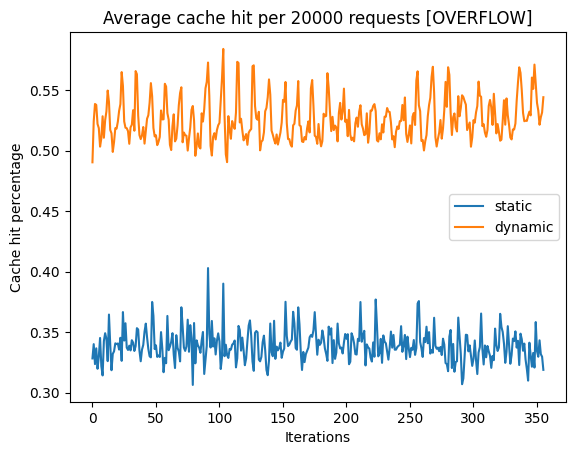

In [26]:
import matplotlib.pyplot as plt

plt.plot(intervals_static, label="static")
plt.plot(intervals_dynamic, label="dynamic")
plt.legend()
plt.title('Average cache hit per 20000 requests [OVERFLOW]')
plt.ylabel('Cache hit percentage')
plt.xlabel('Iterations')

In [13]:
edges = data.edge_index.t()
dic_temp = {}
for i in range(len(edges[len(edges) - 2*subset:])):
    src = int(edges[i][0])
    dst = int(edges[i][1])
    tup = (src, dst)
    if src in dic_temp:
        dic_temp[src] += 1
    else:
        dic_temp[src] = 1
    
    if dst in dic_temp:
        dic_temp[dst] += 1
    else:
        dic_temp[src] = 1

In [8]:
# Percentage of all edges that are repeated
edges = data.edge_index.t()
dic = {}
for i in range(len(edges)):
    src = int(edges[i][0])
    dst = int(edges[i][1])
    tup = (src, dst)
    if tup in dic:
        dic[tup] += 1
    else:
        dic[tup] = 1


# We hypothesise 

In [57]:
# Number of unique edges
len(dic)

36233450

In [9]:
edge_repeats = dic.values()

In [62]:
edge_repeats = list(edge_repeats)

In [10]:
only_ones = [i for i in edge_repeats if i==1]
not_start = [i for i in edge_repeats if i !=1 and i !=2 and i!=3]
only_twos = [i for i in edge_repeats if i==2]
only_threes = [i for i in edge_repeats if i==3]

In [13]:
sum(only_ones) + sum(only_twos) + sum(only_threes)

42213961

In [12]:
sum(not_start)

21283089

In [64]:
len(only_ones)

28199827

In [77]:
len(only_twos)

4623594

In [82]:
len(only_threes)

1588982

In [84]:
len(not_start)

1821047

(0.0, 250.0)

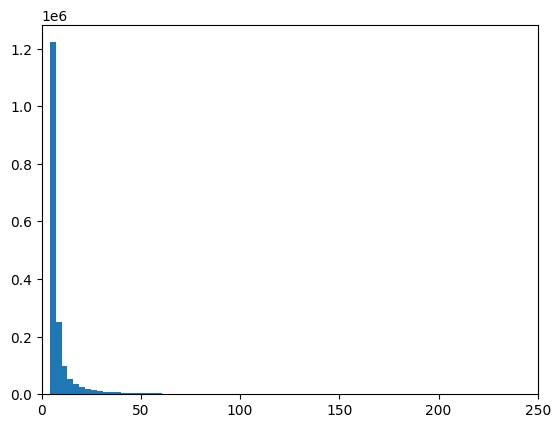

In [85]:
plt.hist(not_start, 10000)
plt.xlim([0,250])

In [28]:
t = torch.load('LRU_subset_1.0Ccache_10.pt')
t = list(t)

intervals_dynamic = sum_intervals(t)
getHitRate(intervals_dynamic)

tensor(0.5105)

Text(0.5, 0, 'Iterations')

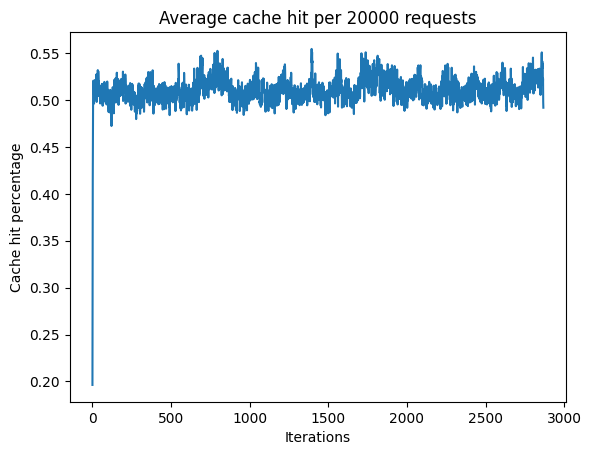

In [29]:
import matplotlib.pyplot as plt

plt.plot(intervals_dynamic)
plt.title('Average cache hit per 20000 requests')
plt.ylabel('Cache hit percentage')
plt.xlabel('Iterations')

In [7]:
# For LRU
cacheSizes = [10,20,40,60,80]
LRU_hits = [51.05, 63.94, 77.08, 84.17, 88.67]

# For static
static_hits = [55.36, 66.03, 76.79, 82.93, 87.09]

In [31]:
t = torch.load('static_subset_1.0Ccache_10.pt')
sum(t)

In [12]:
# Sanity check in/out neighbours correct

nds = torch.tensor([22656, 1144035], dtype=torch.long)
test_loader = NeighborSampler(data.edge_index, sizes=[-1], node_idx=nds, batch_size=1)
for batch_size, ids, adjs in test_loader:
    print(ids.size())

torch.Size([22258])
torch.Size([14743])
